# Patch-based Transformation

## Import

In [27]:
import numpy as np
import timm
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

from util import imagenet_ind2str


## Hyper parameter

In [93]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    gpu = 'cuda:' + str(gpu_ids[0])  # GPU Number
else:
    gpu = "cuda" if torch.cuda.is_available() else "cpu"
device = gpu
# device = 'mps'
BATCH_SIZE = 1
NUM_WORKERS = 2

[0, 1, 2, 3]
['TITAN Xp', 'TITAN Xp', 'TITAN Xp', 'TITAN Xp']


## Dataset

In [29]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_origin = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
origin_set = datasets.ImageFolder('./data/ImageNet/val', transform=transform_origin)
test_set = datasets.ImageFolder('./data/ImageNet/val', transform=transform_test)
origin_loader = DataLoader(origin_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## Transformation methods

In [30]:
def shuffler(img):
    d = 7
    sub_imgs = []
    for i in range(d):
        for j in range(d):
            sub_img = img[i * 224 // d:(i + 1) * 224 // d, j * 224 // d:(j + 1) * 224 // d]
            sub_imgs.append(sub_img)
    np.random.shuffle(sub_imgs)
    new_img = np.vstack([np.hstack([sub_imgs[i] for i in range(d*j, d*(j+1))]) for j in range(d)])
    return new_img

def rotator(img):
    d = 7
    sub_imgs = []
    for i in range(d):
        for j in range(d):
            sub_img = img[i * 224 // d:(i + 1) * 224 // d, j * 224 // d:(j + 1) * 224 // d]
            sub_imgs.append(sub_img)
    sub_imgs = [np.rot90(sub_img) for sub_img in sub_imgs]
    new_img = np.vstack([np.hstack([sub_imgs[i] for i in range(d * j, d * (j + 1))]) for j in range(d)])
    return new_img

def show_img(n, shuffle=False, rotate=False):
    for i, data in enumerate(origin_loader):
        if i == n:
            inputs, labels = data
            inputs_np, labels_np = inputs.numpy(), labels.numpy()
            inputs_np = np.transpose(inputs_np, (0, 2, 3, 1))[0]
            if shuffle:
                inputs_np = shuffler(inputs_np)
            if rotate:
                inputs_np = rotator(inputs_np)
            plt.imshow(inputs_np)
            plt.title(imagenet_ind2str(int(labels_np)))
            plt.show()
            break

def show_reverse_img(images, labels):
    std_array = np.reshape([0.229, 0.224, 0.225], (1, 1, 3))
    mean_array = np.reshape([0.485, 0.456, 0.406], (1, 1, 3))
    reversed_img = images * std_array + mean_array
    plt.imshow(reversed_img)
    plt.title(imagenet_ind2str(int(labels)))
    plt.show()

def cal_dist(tensor1, tensor2):
    squared_diff = np.square(tensor1 - tensor2)
    sum_squared_diff = np.sum(squared_diff)
    distance = np.sqrt(sum_squared_diff)
    return distance

## Class 선언

In [245]:
class PatchHeatMap(object):
    def __init__(self):
        self.model = None
        self.model_cnn = None
        self.img_origin = None
        self.img_trans = None
        self.labels = None
        self.tensor_origin = None
        self.tensor_trans = None
        self.conf_origin = 0
        self.conf_trans = 0
        self.conf_diff = []
        self.list_labels = []

    def process_v(self, n, shuffle=False, rotate=False):
        self.build_model()
        self.build_model_cnn()
        self.extract_tnc_compare(n, shuffle, rotate)
        self.visual()

    def process_g(self, shuffle=False, rotate=False):
        self.build_model()
        self.grouping(shuffle, rotate)
        
    def process_g_cnn(self, shuffle=False, rotate=False):
        self.build_model_cnn()
        self.grouping_cnn(shuffle, rotate)

    def process_d(self, n, shuffle=False, rotate=False):
        self.build_model()
        self.build_model_cnn()
        self.extract_tnc_compare(n, shuffle, rotate)

    def build_model(self):
        self.model = timm.models.vit_base_patch16_224(pretrained=True)
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'Classes: {self.model.num_classes}')
        print(f'****** Model Creating Completed. ******\n')

    def build_model_cnn(self):
        self.model_cnn = torch.hub.load('szq0214/MEAL-V2','meal_v2', 'mealv2_resnest50_cutmix', pretrained=True)
        print(f'Parameter: {sum(p.numel() for p in self.model_cnn.parameters() if p.requires_grad)}')
        print(f'****** Model Creating Completed. ******\n')

    def extract_tnc(self, n, shuffle, rotate):
        self.model.to(device).eval()
        with torch.no_grad():
            (images, labels) = test_set[n]
            images = images.reshape(1, 3, 224, 224).float()
            labels = torch.tensor(labels)
            images = images.numpy()
            images = np.transpose(images, (0, 2, 3, 1))[0]
            images_t = images
            if shuffle:
                images_t = shuffler(images_t)
            if rotate:
                images_t = rotator(images_t)

            self.img_origin = images
            self.img_trans = images_t
            self.labels = labels

            images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images = images.to(device)
            labels = labels.to(device)
            outputs, self.tensor_origin = self.model(images)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            self.conf_origin = probs[int(labels)].to('cpu')

            images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images_t = images_t.to(device)
            labels = labels.to(device)
            outputs, self.tensor_trans = self.model(images_t)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            self.conf_trans = probs[int(labels)].to('cpu')

    def visual(self):
        show_reverse_img(self.img_origin, self.labels)
        show_reverse_img(self.img_trans, self.labels)
        print(f'Label : {imagenet_ind2str(int(self.labels))}')
        print(f'Confidence of origin : {float(self.conf_origin):.3f}')
        print(f'Confidence of trans : {float(self.conf_trans):.3f}')

        np_origin = self.tensor_origin.to('cpu').numpy()
        np_origin = np_origin.reshape(197, 768)
        np_origin = np.delete(np_origin, 0, axis=0)
        np_trans = self.tensor_trans.to('cpu').numpy()
        np_trans = np_trans.reshape(197, 768)
        np_trans = np.delete(np_trans, 0, axis=0)

        dists = [cal_dist(i, j) for i, j in zip(np_origin, np_trans)]
        df = np.array(dists).reshape(14, 14)

        sns.heatmap(data=df,
                    annot=True,
                    cmap='Oranges',
                    linewidths=.5,
                    vmax=50,
                    vmin=-0,
                    cbar_kws={'shrink': .5})
        plt.show()

    def grouping(self, shuffle, rotate):
        self.model.to(device).eval()
        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
                images = images.numpy()
                images = np.transpose(images, (0, 2, 3, 1))[0]
                images_t = images
                if shuffle:
                    images_t = shuffler(images_t)
                if rotate:
                    images_t = rotator(images_t)

                self.img_origin = images
                self.img_trans = images_t
                self.labels = labels

                images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images = images.to(device)
                labels = labels.to(device)
                outputs, __ = self.model(images)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)[0]
                self.conf_origin = probs[int(labels)].to('cpu')

                images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images_t = images_t.to(device)
                labels = labels.to(device)
                outputs, __ = self.model(images_t)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)[0]
                self.conf_trans = probs[int(labels)].to('cpu')

                self.conf_diff.append(float(self.conf_origin-self.conf_trans))
                self.list_labels.append(int(self.labels))

    def extract_tnc_compare(self, n, shuffle, rotate):
        self.model.to(device).eval()
        self.model_cnn.to(device).eval()
        with torch.no_grad():
            (images, labels) = test_set[n]
            images = images.reshape(1, 3, 224, 224).float()
            labels = torch.tensor(labels)
            images = images.numpy()
            images = np.transpose(images, (0, 2, 3, 1))[0]
            images_t = images
            if shuffle:
                images_t = shuffler(images_t)
            if rotate:
                images_t = rotator(images_t)

            self.img_origin = images
            self.img_trans = images_t
            self.labels = labels

            images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images = images.to(device)
            labels = labels.to(device)
            outputs, self.tensor_origin = self.model(images)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            self.conf_origin = probs[int(labels)].to('cpu')

            images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images_t = images_t.to(device)
            labels = labels.to(device)
            outputs, self.tensor_trans = self.model(images_t)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            self.conf_trans = probs[int(labels)].to('cpu')

            print(f'Label : {imagenet_ind2str(int(self.labels))}')
            
            print(f'Diff of ViT : {float(self.conf_origin)-float(self.conf_trans):.3f}')
            print(f'Confidence of origin (ViT) : {float(self.conf_origin):.3f}')
            print(f'Confidence of trans (ViT) : {float(self.conf_trans):.3f}')

            outputs = self.model_cnn(images)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            self.conf_origin = probs[0, int(labels)].to('cpu')

            outputs = self.model_cnn(images_t)
            _, pred = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            self.conf_trans = probs[0, int(labels)].to('cpu')

            print(f'Diff of CNN : {float(self.conf_origin) - float(self.conf_trans):.3f}')
            print(f'Confidence of origin (CNN) : {float(self.conf_origin):.3f}')
            print(f'Confidence of trans (CNN) : {float(self.conf_trans):.3f}')

    def grouping_cnn(self, shuffle, rotate):
        self.model_cnn.to(device).eval()
        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
                images = images.numpy()
                images = np.transpose(images, (0, 2, 3, 1))[0]
                images_t = images
                if shuffle:
                    images_t = shuffler(images_t)
                if rotate:
                    images_t = rotator(images_t)

                self.img_origin = images
                self.img_trans = images_t
                self.labels = labels

                images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model_cnn(images)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                self.conf_origin = probs[0, int(labels)].to('cpu')

                images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images_t = images_t.to(device)
                labels = labels.to(device)
                outputs = self.model_cnn(images_t)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                self.conf_trans = probs[0, int(labels)].to('cpu')

                self.conf_diff.append(float(self.conf_origin-self.conf_trans))
                self.list_labels.append(int(self.labels))


## Iteration

In [32]:
p = PatchHeatMap()
p.process_g(shuffle=True)
conf_diff = p.conf_diff
list_labels = p.list_labels
print(len(conf_diff))
print(len(list_labels))

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Cross check

In [ ]:
print(list_labels.count(0))
print(len(set(list_labels)))

## Average confidnece

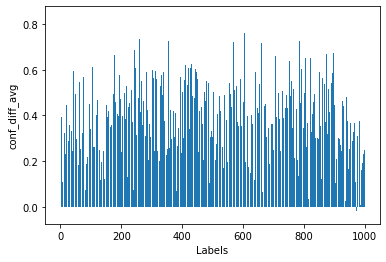

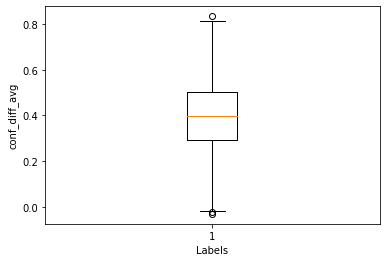

In [71]:
groups = [conf_diff[i:i+50] for i in range(0, len(conf_diff), 50)]
conf_avg = [sum(group) / len(group) for group in groups]
labels = [i for i in range(1000)]

data = {'labels': labels, 'conf_diff_avg': conf_avg}
df = pd.DataFrame(data)

plt.bar(df['labels'], df['conf_diff_avg'])
plt.xlabel('Labels')
plt.ylabel('conf_diff_avg')
plt.show()

plt.boxplot(df['conf_diff_avg'])
plt.xlabel('Labels')
plt.ylabel('conf_diff_avg')
plt.show()

## Take max group and min group

In [72]:
df_sorted = df.sort_values('conf_diff_avg', ascending=False)
print(df_sorted.head(5))
print(df_sorted.tail(5))

     labels  conf_diff_avg
475     475       0.835058
48       48       0.812818
666     666       0.805029
528     528       0.782893
564     564       0.764266
     labels  conf_diff_avg
986     986       0.006861
323     323      -0.002053
973     973      -0.017095
992     992      -0.021546
386     386      -0.031582


Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.989
Confidence of origin (ViT) : 0.991
Confidence of trans (ViT) : 0.001
Diff of CNN : 0.950
Confidence of origin (CNN) : 0.952
Confidence of trans (CNN) : 0.002


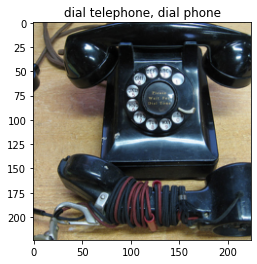

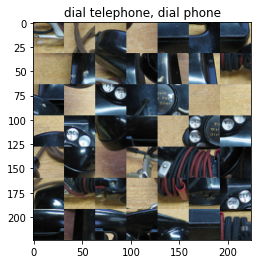

Label : dial telephone, dial phone
Confidence of origin : 0.952
Confidence of trans : 0.002


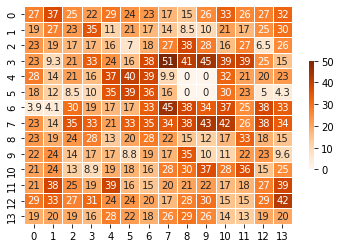

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.990
Confidence of origin (ViT) : 0.992
Confidence of trans (ViT) : 0.001
Diff of CNN : 0.962
Confidence of origin (CNN) : 0.962
Confidence of trans (CNN) : 0.001


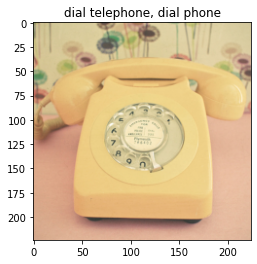

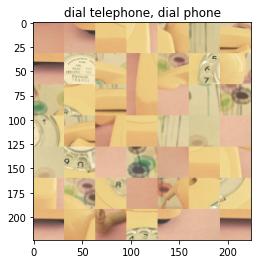

Label : dial telephone, dial phone
Confidence of origin : 0.962
Confidence of trans : 0.001


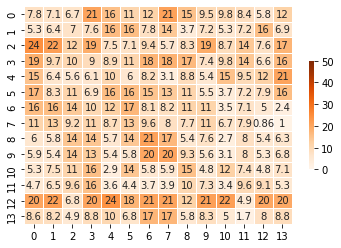

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.902
Confidence of origin (ViT) : 0.902
Confidence of trans (ViT) : 0.000
Diff of CNN : 0.898
Confidence of origin (CNN) : 0.898
Confidence of trans (CNN) : 0.000


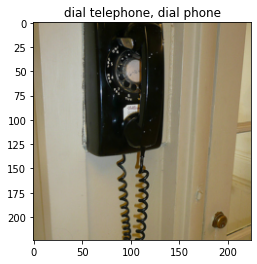

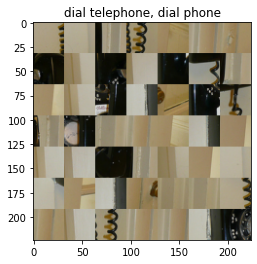

Label : dial telephone, dial phone
Confidence of origin : 0.898
Confidence of trans : 0.000


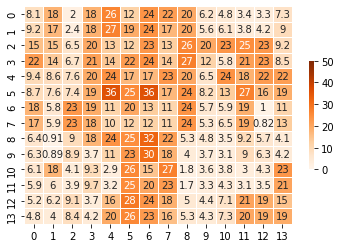

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.003
Confidence of origin (ViT) : 0.003
Confidence of trans (ViT) : 0.000
Diff of CNN : 0.110
Confidence of origin (CNN) : 0.111
Confidence of trans (CNN) : 0.001


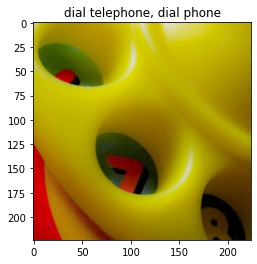

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


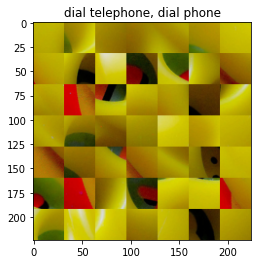

Label : dial telephone, dial phone
Confidence of origin : 0.111
Confidence of trans : 0.001


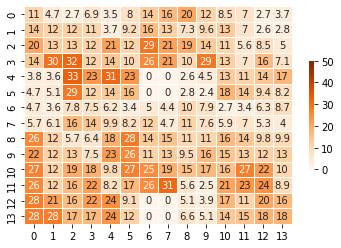

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.978
Confidence of origin (ViT) : 0.979
Confidence of trans (ViT) : 0.001
Diff of CNN : 0.975
Confidence of origin (CNN) : 0.978
Confidence of trans (CNN) : 0.002


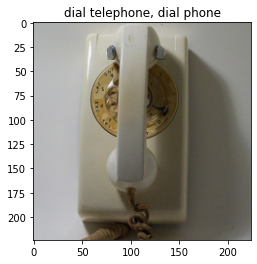

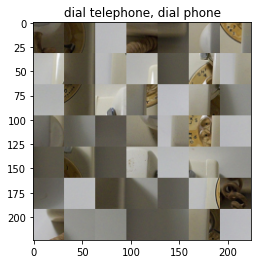

Label : dial telephone, dial phone
Confidence of origin : 0.978
Confidence of trans : 0.002


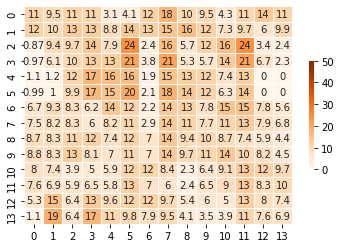

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.870
Confidence of origin (ViT) : 0.874
Confidence of trans (ViT) : 0.004
Diff of CNN : 0.887
Confidence of origin (CNN) : 0.887
Confidence of trans (CNN) : 0.000


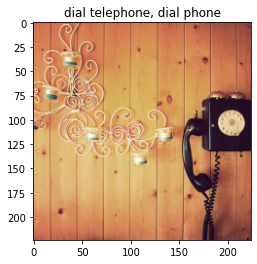

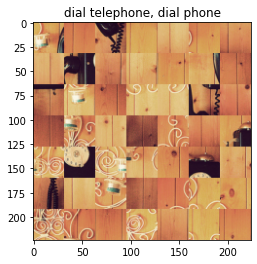

Label : dial telephone, dial phone
Confidence of origin : 0.887
Confidence of trans : 0.000


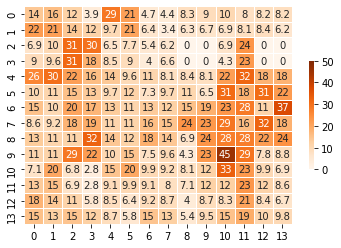

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.257
Confidence of origin (ViT) : 0.987
Confidence of trans (ViT) : 0.730
Diff of CNN : 0.938
Confidence of origin (CNN) : 0.956
Confidence of trans (CNN) : 0.018


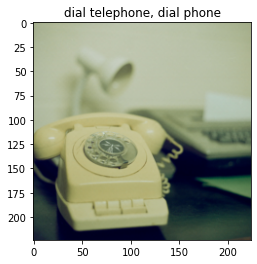

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


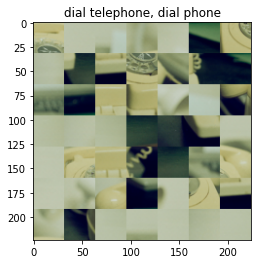

Label : dial telephone, dial phone
Confidence of origin : 0.956
Confidence of trans : 0.018


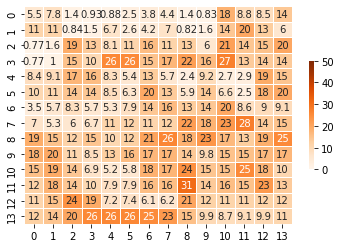

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.147
Confidence of origin (ViT) : 0.147
Confidence of trans (ViT) : 0.000
Diff of CNN : 0.829
Confidence of origin (CNN) : 0.836
Confidence of trans (CNN) : 0.007


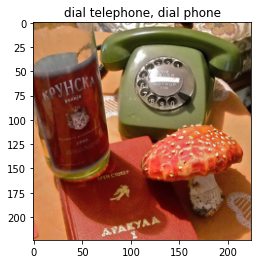

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


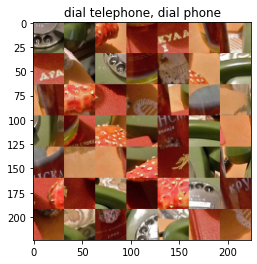

Label : dial telephone, dial phone
Confidence of origin : 0.836
Confidence of trans : 0.007


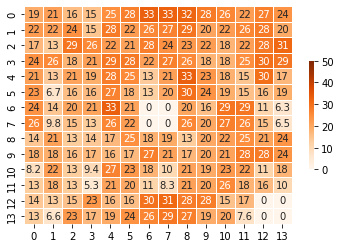

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.825
Confidence of origin (ViT) : 0.826
Confidence of trans (ViT) : 0.001
Diff of CNN : 0.792
Confidence of origin (CNN) : 0.793
Confidence of trans (CNN) : 0.000


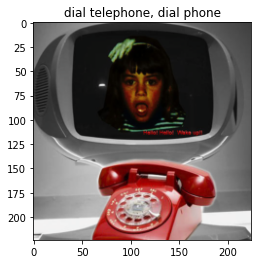

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


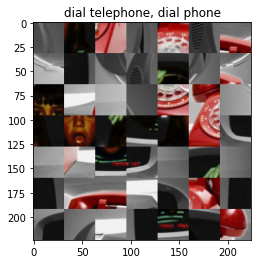

Label : dial telephone, dial phone
Confidence of origin : 0.793
Confidence of trans : 0.000


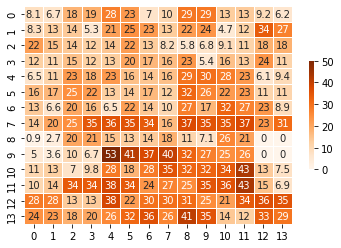

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : dial telephone, dial phone
Diff of ViT : 0.972
Confidence of origin (ViT) : 0.972
Confidence of trans (ViT) : 0.000
Diff of CNN : 0.956
Confidence of origin (CNN) : 0.957
Confidence of trans (CNN) : 0.001


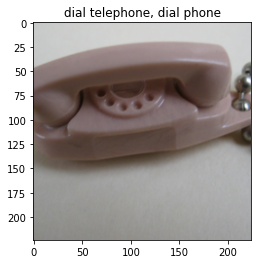

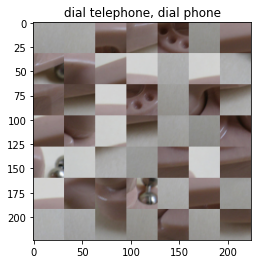

Label : dial telephone, dial phone
Confidence of origin : 0.957
Confidence of trans : 0.001


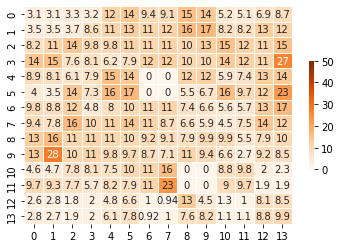

In [270]:
p2 = PatchHeatMap()
n = 528*50
p2.process_v(n+10, shuffle=True)
p2.process_v(n+11, shuffle=True)
p2.process_v(n+12, shuffle=True)
p2.process_v(n+13, shuffle=True)
p2.process_v(n+14, shuffle=True)
p2.process_v(n+15, shuffle=True)
p2.process_v(n+16, shuffle=True)
p2.process_v(n+17, shuffle=True)
p2.process_v(n+18, shuffle=True)
p2.process_v(n+19, shuffle=True)

In [204]:
p2 = PatchHeatMap()
n = 386*50
p2.process_d(n+0, shuffle=True)
p2.process_d(n+1, shuffle=True)
p2.process_d(n+2, shuffle=True)
p2.process_d(n+3, shuffle=True)
p2.process_d(n+4, shuffle=True)
p2.process_d(n+5, shuffle=True)
p2.process_d(n+6, shuffle=True)
p2.process_d(n+7, shuffle=True)
p2.process_d(n+8, shuffle=True)
p2.process_d(n+9, shuffle=True)

Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : African elephant, Loxodonta africana
Diff of ViT : 0.630
Diff of CNN : -0.139
Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : African elephant, Loxodonta africana
Diff of ViT : -0.023
Diff of CNN : 0.217
Parameter: 86567656
Classes: 1000
****** Model Creating Completed. ******



Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******

Label : African elephant, Loxodonta africana
Diff of ViT : -0.012
Diff of CNN : 0.387


KeyboardInterrupt: 

## Average confidnece_CNN

Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******



  0%|          | 0/50000 [00:00<?, ?it/s]

50000
50000


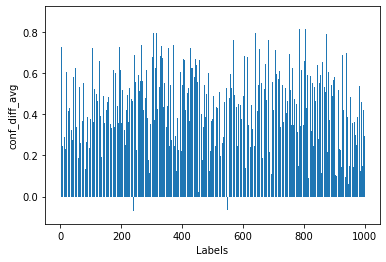

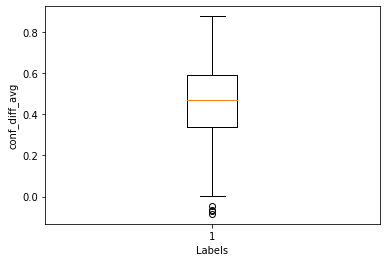

In [136]:
p_cnn = PatchHeatMap()
p_cnn.process_g_cnn(shuffle=True)
conf_diff = p_cnn.conf_diff
list_labels = p_cnn.list_labels
print(len(conf_diff))
print(len(list_labels))

groups = [conf_diff[i:i+50] for i in range(0, len(conf_diff), 50)]
conf_avg = [sum(group) / len(group) for group in groups]
labels = [i for i in range(1000)]

data = {'labels': labels, 'conf_diff_avg': conf_avg}
df = pd.DataFrame(data)

plt.bar(df['labels'], df['conf_diff_avg'])
plt.xlabel('Labels')
plt.ylabel('conf_diff_avg')
plt.show()

plt.boxplot(df['conf_diff_avg'])
plt.xlabel('Labels')
plt.ylabel('conf_diff_avg')
plt.show()

In [138]:
df_sorted = df.sort_values('conf_diff_avg', ascending=False)
print(df_sorted.head(5))
print(df_sorted.tail(5))

     labels  conf_diff_avg
604     604       0.875665
606     606       0.868782
51       51       0.861009
125     125       0.859765
719     719       0.858072
     labels  conf_diff_avg
948     948       0.004715
340     340      -0.047042
549     549      -0.066461
240     240      -0.071909
987     987      -0.084223


In [179]:
class PatchHeatMapCNN(object):
    def __init__(self):
        self.model = None
        self.img_origin = None
        self.img_trans = None
        self.labels = None
        self.tensor_origin = None
        self.tensor_trans = None
        self.conf_origin = 0
        self.conf_trans = 0
        self.conf_diff = []
        self.list_labels = []
        self.pred_origin = None
        self.pred_trans = None

    def process_v(self, n, shuffle=False, rotate=False):
        self.build_model()
        self.extract_tnc(n, shuffle, rotate)
        self.visual()

    def process_g(self, shuffle=False, rotate=False):
        self.build_model()
        self.grouping(shuffle, rotate)

    def build_model(self):
        self.model = torch.hub.load('szq0214/MEAL-V2','meal_v2', 'mealv2_resnest50_cutmix', pretrained=True)
        print(f'Parameter: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}')
        print(f'****** Model Creating Completed. ******\n')

    def extract_tnc(self, n, shuffle, rotate):
        self.model.to(device).eval()
        with torch.no_grad():
            (images, labels) = test_set[n]
            images = images.reshape(1, 3, 224, 224).float()
            labels = torch.tensor(labels)
            images = images.numpy()
            images = np.transpose(images, (0, 2, 3, 1))[0]
            images_t = images
            if shuffle:
                images_t = shuffler(images_t)
            if rotate:
                images_t = rotator(images_t)

            self.img_origin = images
            self.img_trans = images_t
            self.labels = labels

            images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            _, pred = torch.max(outputs, 1)
            self.pred_origin = int(pred.to('cpu'))
            probs = torch.nn.functional.softmax(outputs, dim=1)
            self.conf_origin = probs[0, int(self.labels)].to('cpu')

            images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
            images_t = images_t.to(device)
            labels = labels.to(device)
            outputs = self.model(images_t)
            _, pred = torch.max(outputs, 1)
            self.pred_trans = int(pred.to('cpu'))
            probs = torch.nn.functional.softmax(outputs, dim=1)
            self.conf_trans = probs[0, int(self.labels)].to('cpu')

    def visual(self):
        show_reverse_img(self.img_origin, self.labels)
        show_reverse_img(self.img_trans, self.labels)
        print(f'Label : {imagenet_ind2str(int(self.labels))}')
        print(f'Prediction of origin : {imagenet_ind2str(self.pred_origin)}')
        print(f'Prediction of trans : {imagenet_ind2str(self.pred_trans)}')
        print(f'Confidence of origin : {float(self.conf_origin):.3f}')
        print(f'Confidence of trans : {float(self.conf_trans):.3f}')
        print(f'Diff : {float(self.conf_origin) - float(self.conf_trans):.3f}')

    def grouping(self, shuffle, rotate):
        self.model.to(device).eval()
        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
                images = images.numpy()
                images = np.transpose(images, (0, 2, 3, 1))[0]
                images_t = images
                if shuffle:
                    images_t = shuffler(images_t)
                if rotate:
                    images_t = rotator(images_t)

                self.img_origin = images
                self.img_trans = images_t
                self.labels = labels

                images = torch.from_numpy(images.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images = images.to(device)
                labels = labels.to(device)
                outputs, __ = self.model(images)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)[0]
                self.conf_origin = probs[int(labels)].to('cpu')

                images_t = torch.from_numpy(images_t.transpose((2, 0, 1)).reshape(1, 3, 224, 224)).float()
                images_t = images_t.to(device)
                labels = labels.to(device)
                outputs, __ = self.model(images_t)
                _, pred = torch.max(outputs, 1)
                probs = torch.nn.functional.softmax(outputs, dim=1)[0]
                self.conf_trans = probs[int(labels)].to('cpu')

                self.conf_diff.append(float(self.conf_origin-self.conf_trans))
                self.list_labels.append(int(self.labels))


Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Parameter: 25557032
****** Model Creating Completed. ******



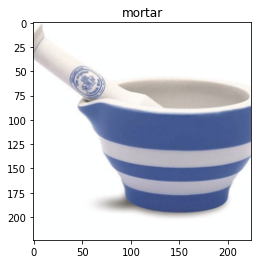

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


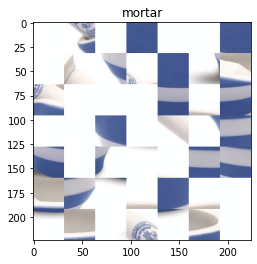

Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Label : mortar
Prediction of origin : mortar
Prediction of trans : web site, website, internet site, site
Confidence of origin : 0.574
Confidence of trans : 0.001
Diff : 0.573
Parameter: 25557032
****** Model Creating Completed. ******



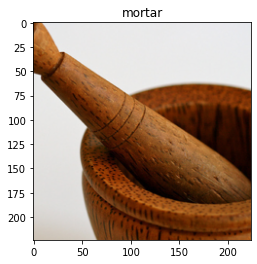

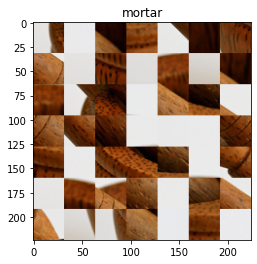

Label : mortar
Prediction of origin : mortar
Prediction of trans : coil, spiral, volute, whorl, helix
Confidence of origin : 0.987
Confidence of trans : 0.006
Diff : 0.980


Using cache found in /root/.cache/torch/hub/szq0214_MEAL-V2_master


Parameter: 25557032
****** Model Creating Completed. ******



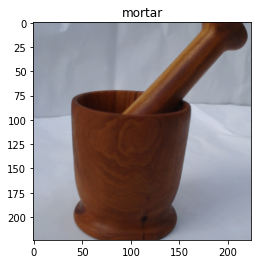

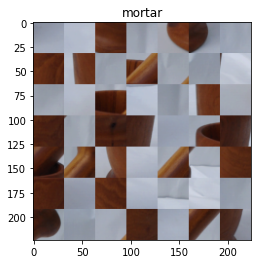

Label : mortar
Prediction of origin : mortar
Prediction of trans : wooden spoon
Confidence of origin : 0.984
Confidence of trans : 0.010
Diff : 0.975


In [228]:
_ = PatchHeatMapCNN()
n = 666*50
_.process_v(n+0, shuffle=True)
_.process_v(n+1, shuffle=True)
_.process_v(n+2, shuffle=True)

In [216]:
print(df_sorted.loc[df['labels'] == 986])
print(df_sorted.loc[df['labels'] == 323])
print(df_sorted.loc[df['labels'] == 973])
print(df_sorted.loc[df['labels'] == 992])
print(df_sorted.loc[df['labels'] == 386])

     labels  conf_diff_avg
475     475       0.746211
    labels  conf_diff_avg
48      48        0.78902
     labels  conf_diff_avg
666     666        0.77314
     labels  conf_diff_avg
528     528       0.837951
     labels  conf_diff_avg
564     564       0.772582
